In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import shap
from sklearn.metrics import confusion_matrix

/Users/alexanderleonidas/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MODELS

In [2]:
# Load pre-processed data
formatted_data = pd.read_csv('data/formatted_data.csv',sep=";")

features = formatted_data.drop(columns=['Target'])
target = formatted_data['Target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Random Seed
RANDOM_SEED = 42

# k-Fold Validation
k = 5
cv = StratifiedKFold(n_splits=k, random_state=RANDOM_SEED, shuffle=True)

### ROC Plotting Function


In [3]:
def plot_roc_curve(fprs, tprs, figsize=(14, 10)):
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=figsize)

    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Luck', alpha=.8)

    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fprs, tprs)], axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std([auc(fpr, tpr) for fpr, tpr in zip(fprs, tprs)])
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fprs, tprs)], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return fig, ax

In [4]:
def compute_roc_auc(clf, X, y, index):
    y_predict = clf.predict_proba(X.iloc[index])[:, 1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [5]:
def train_and_show_auc(clf, X, y):
    fprs, tprs, scores = [], [], []

    for (train, test), i in zip(cv.split(X, y), range(5)):
        clf.fit(X.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(clf, X, y, train)
        fpr, tpr, auc_score = compute_roc_auc(clf, X, y, test)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)

    plot_roc_curve(fprs, tprs)
    return pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## Random Forests

Confusion Matrix:  [[368  99]
 [ 52 366]]
Precision:  0.7870967741935484


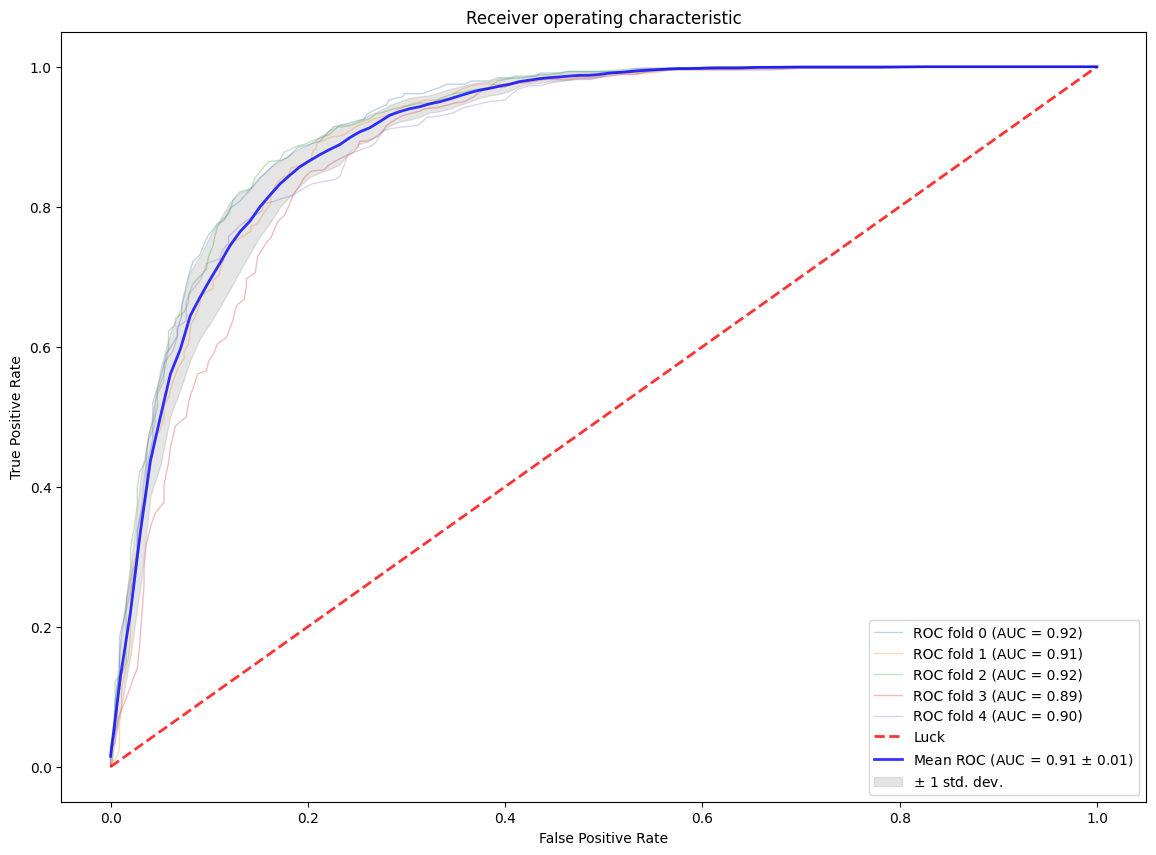

In [6]:
# Train the model
rf_classifier = RandomForestClassifier(random_state=RANDOM_SEED)
rf_classifier.fit(X_train, y_train)

# Generate predictions using the XGBoost model
rf_predictions= rf_classifier.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, rf_predictions)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])

print("Confusion Matrix: ",cm)
print("Precision: ",precision)

rf_scores = train_and_show_auc(rf_classifier, features, target)




## Gradient Boosting

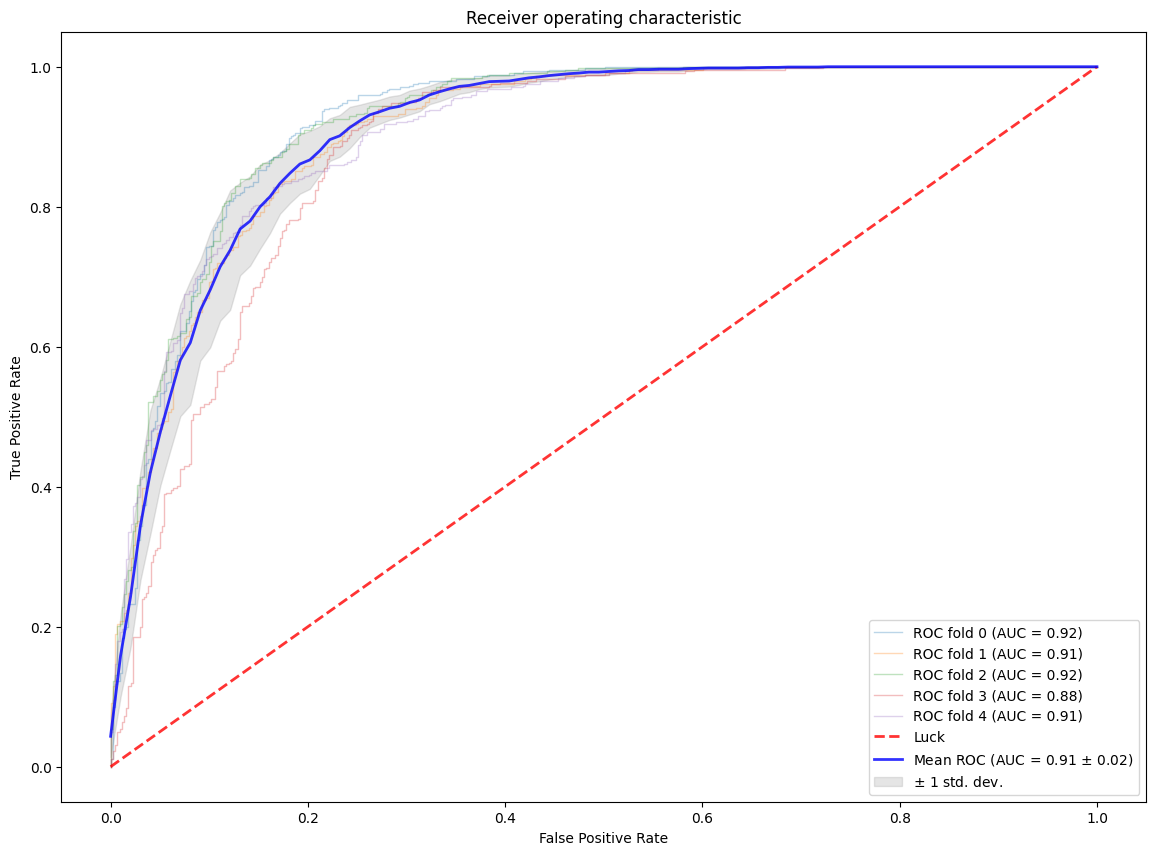

In [7]:
xgb_classifier = xgb.XGBClassifier(random_state=RANDOM_SEED)
xgb_scores = train_and_show_auc(xgb_classifier, features, target)

### xAI methods: Surrogate Model

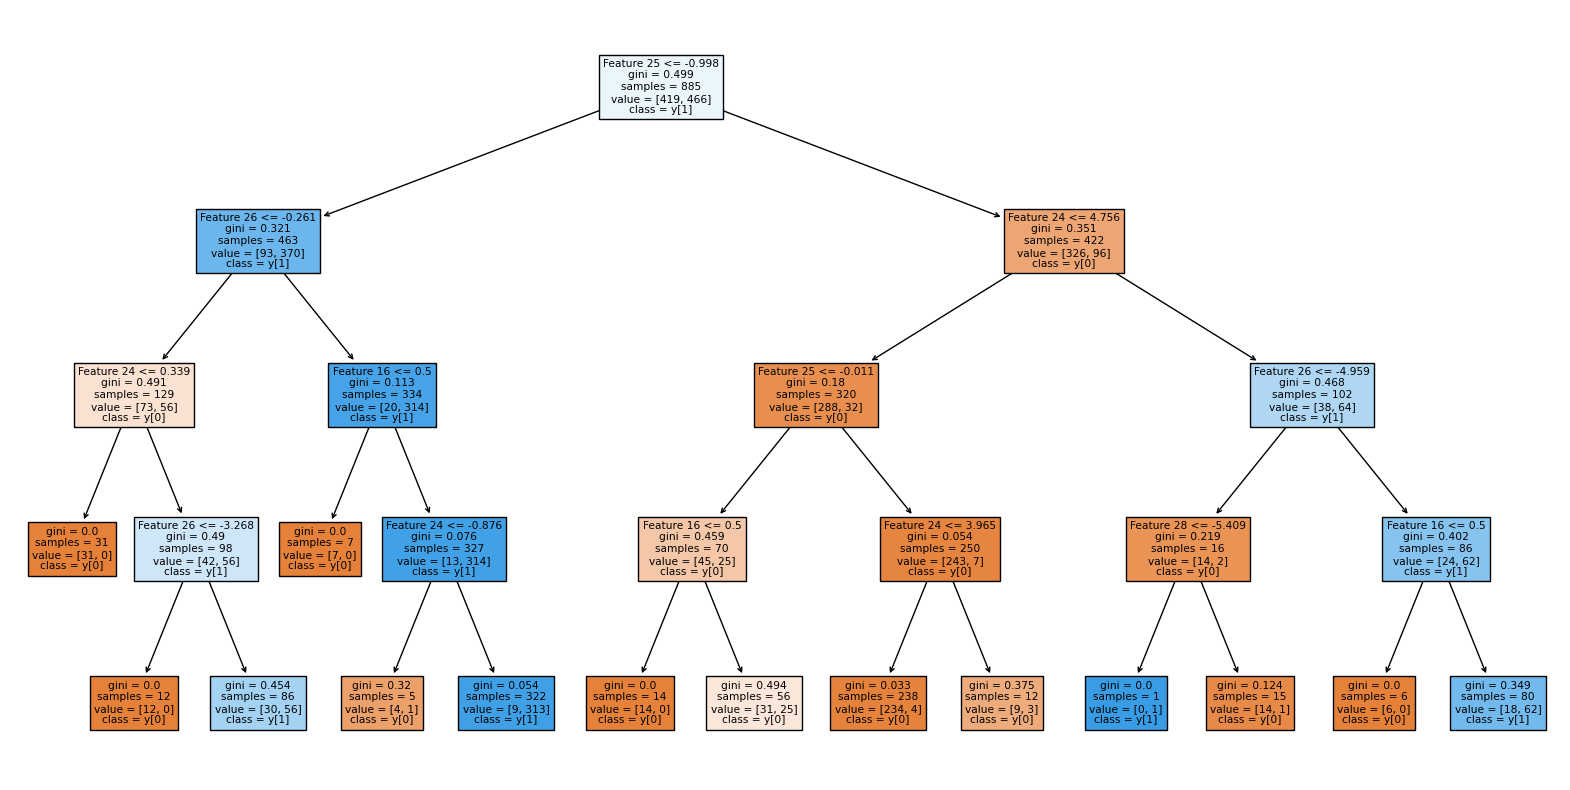

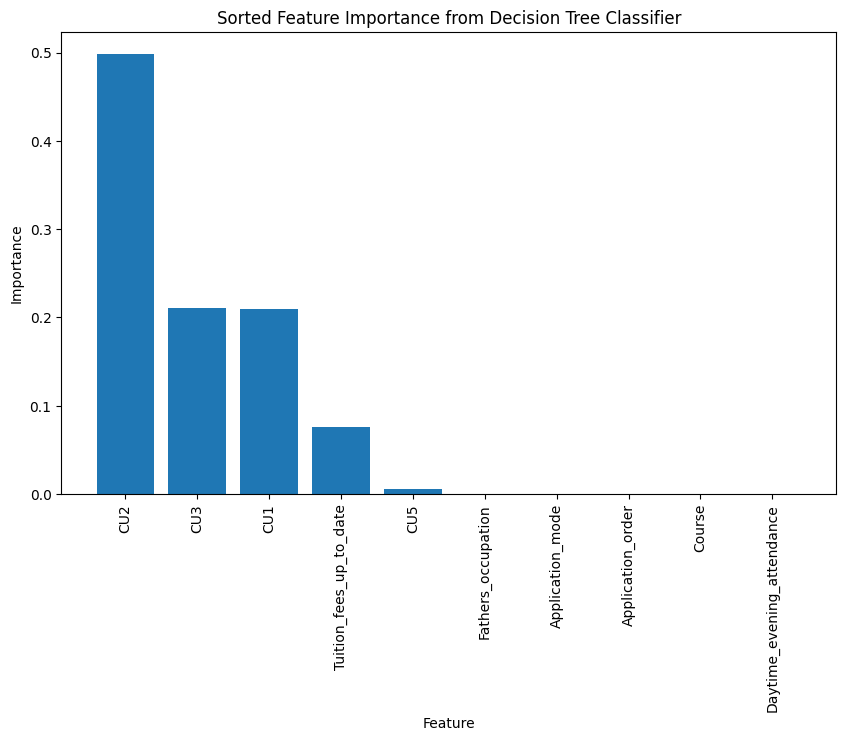

Confusion Matrix:  [[368  99]
 [ 51 367]]
Precision:  0.7875536480686696


In [15]:
# Train the model
xgb_classifier = xgb.XGBClassifier(random_state=RANDOM_SEED)
xgb_classifier.fit(X_train, y_train)

# Generate predictions using the XGBoost model
xgb_predictions = xgb_classifier.predict(X_test)

# Train a Decision Tree as the surrogate model
surrogate_model = DecisionTreeClassifier(max_depth=4)  # Limiting tree depth for simplicity
surrogate_model.fit(X_test, xgb_predictions)
# xgb_scores = train_and_show_auc(surrogate_model, features, target)

# Visualize the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(surrogate_model, filled=True, feature_names=[f'Feature {i}' for i in range(features.shape[1])], class_names=True)
plt.show()

feature_importances = surrogate_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot the sorted feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances[:10])), feature_importances[sorted_idx[:10]], align='center')
plt.xticks(range(len(feature_importances[:10])), np.array(X_test.columns)[sorted_idx[:10]], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Sorted Feature Importance from Decision Tree Classifier')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, xgb_predictions)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
print("Confusion Matrix: ",cm)
print("Precision: ",precision)

### xAI methods: SHAP

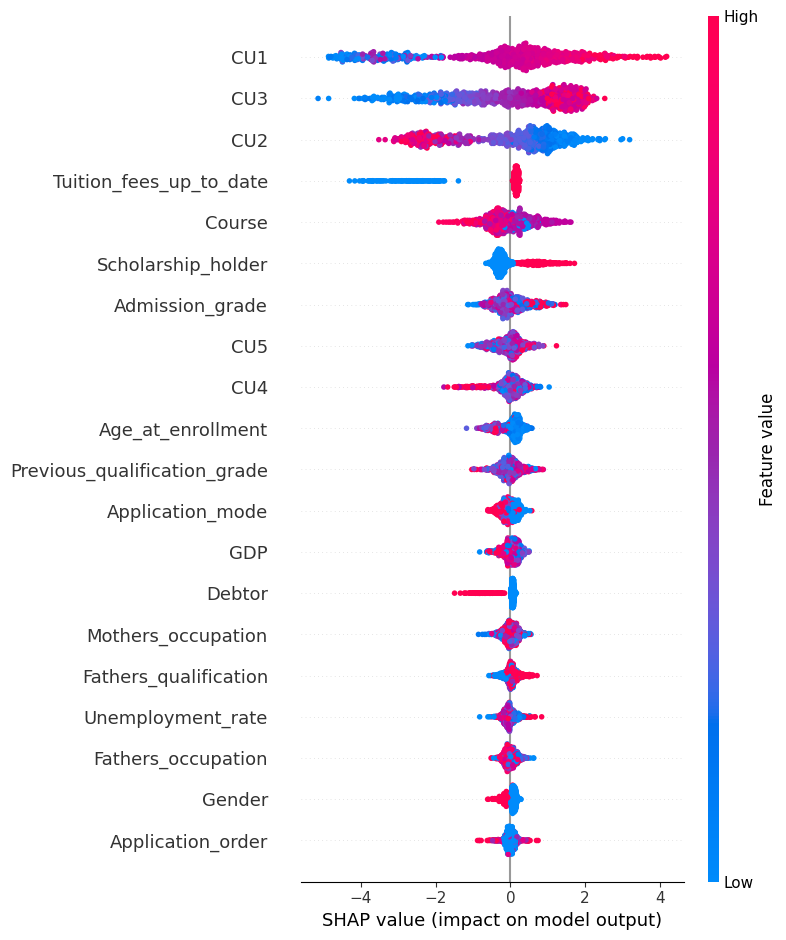

In [9]:
# Initialize SHAP explainer with the fitted model
explainer = shap.Explainer(xgb_classifier)
shap_values = explainer(X_test)

# Plot global summary to understand the impact of each feature
# Note that not all features are in here, only the ones with the greatest contributions
shap.summary_plot(shap_values, X_test)

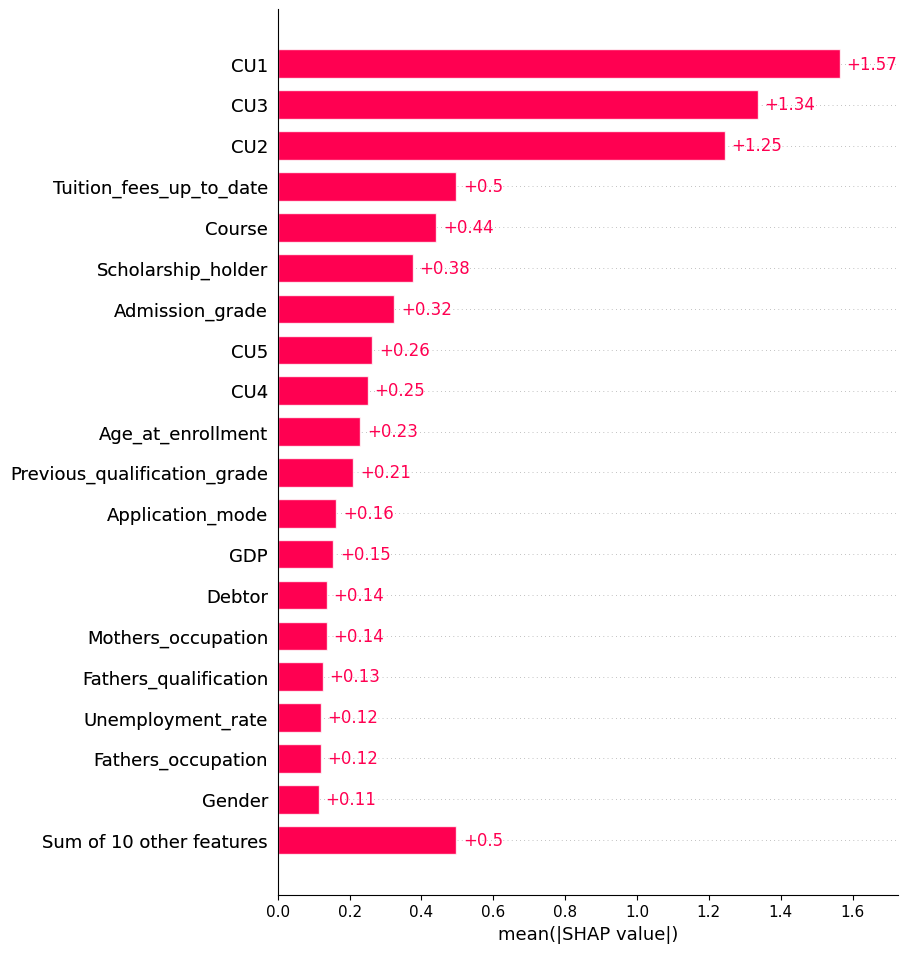

In [10]:
# Can be compared to the other importances we found
shap.plots.bar(shap_values, max_display=20)

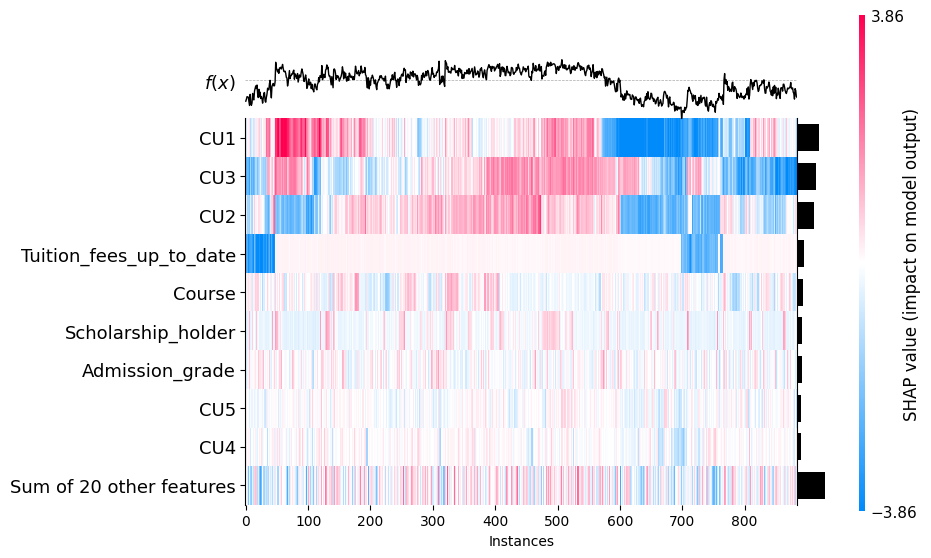

In [11]:
# Somehting strange here, why are the first instances of negative impact?
shap.plots.heatmap(shap_values)

## SVM

Confusion Matrix:  [[ 19 448]
 [ 20 398]]
Precision:  0.47044917257683216


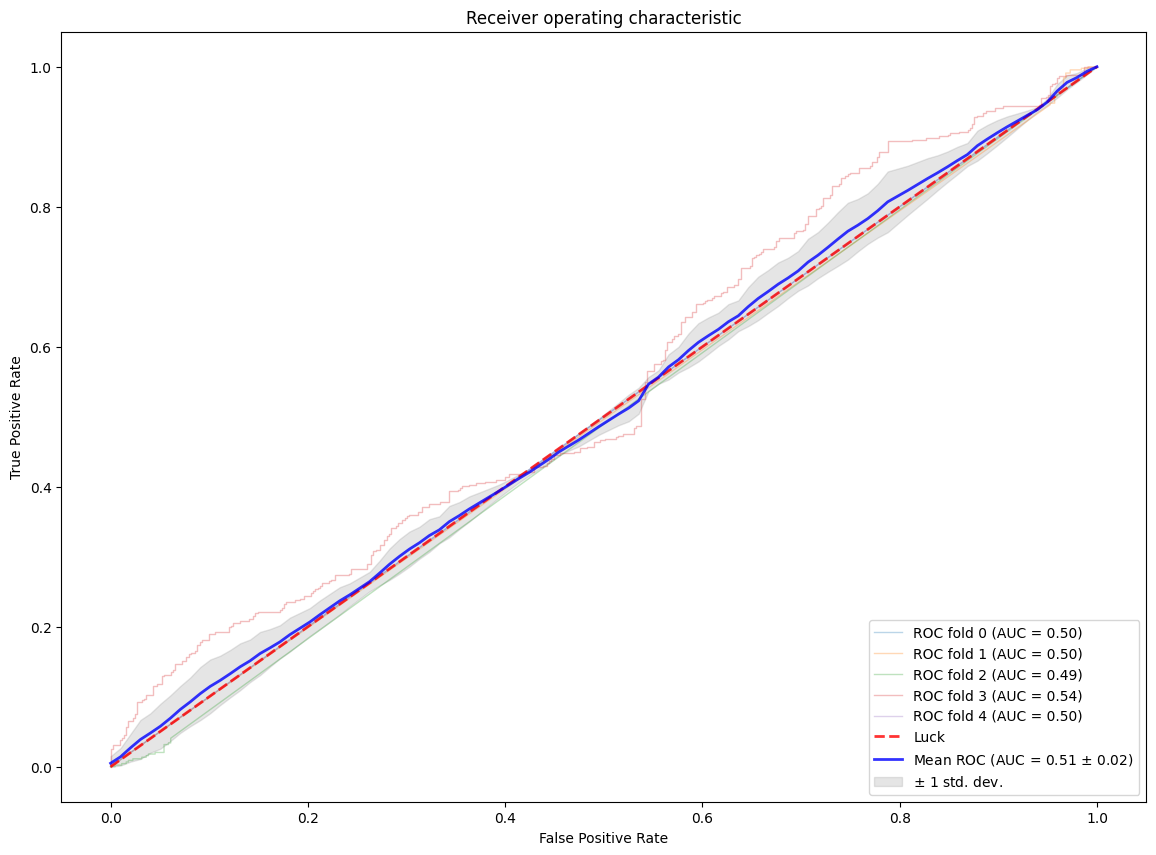

In [12]:
# Train the model
svm_classifier = SVC(random_state=RANDOM_SEED, probability=True)
svm_classifier.fit(X_train, y_train)

# Generate predictions using the XGBoost model
svm_predictions= svm_classifier.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, svm_predictions)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])

print("Confusion Matrix: ",cm)
print("Precision: ",precision)

svm_scores = train_and_show_auc(svm_classifier, features, target)

## Logistic Regression

/Users/alexanderleonidas/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:  [[347 120]
 [ 65 353]]
Precision:  0.7463002114164905


/Users/alexanderleonidas/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alexanderleonidas/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

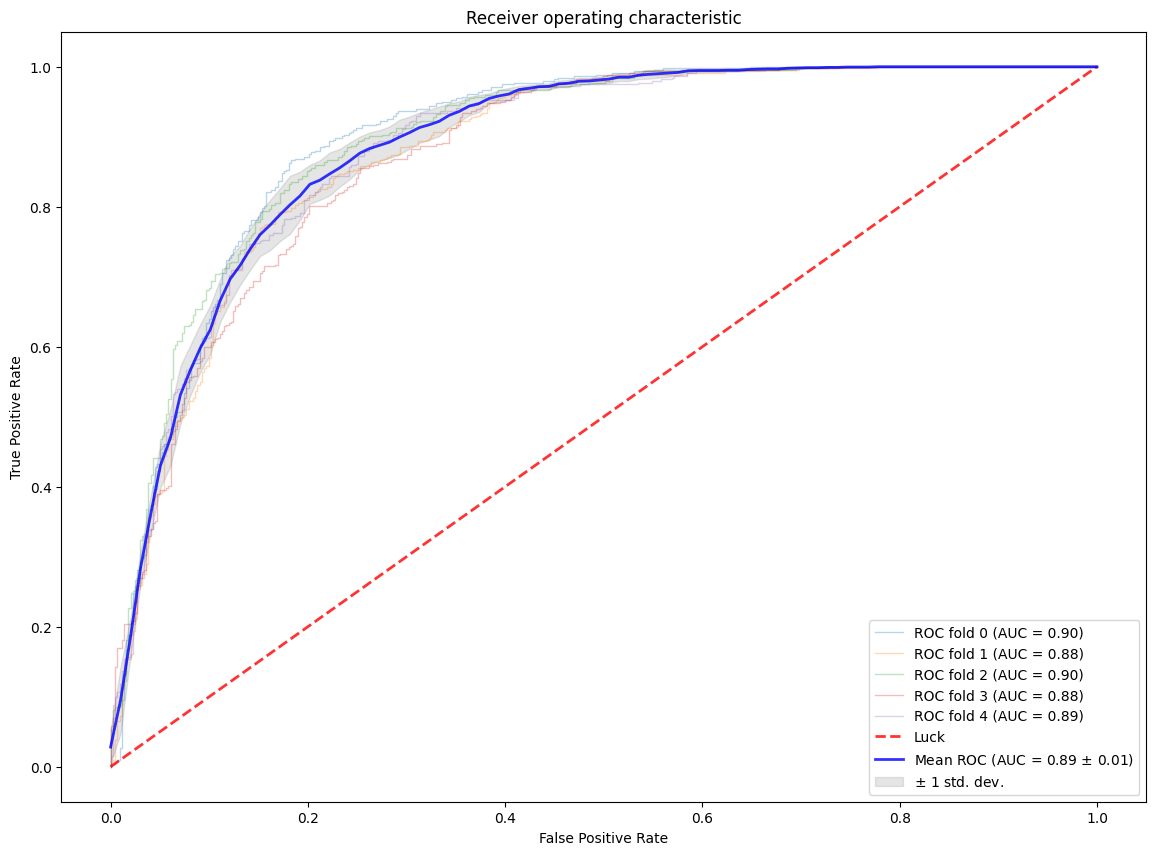

In [13]:
# Train Model
lr_classifier = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
lr_classifier.fit(X_train, y_train)

# Generate predictions using the XGBoost model
lr_predictions= lr_classifier.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, lr_predictions)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])

print("Confusion Matrix: ",cm)
print("Precision: ",precision)

lr_scores = train_and_show_auc(lr_classifier, features, target)

## Neural Network

Confusion Matrix:  [[409  58]
 [126 292]]
Precision:  0.8342857142857143


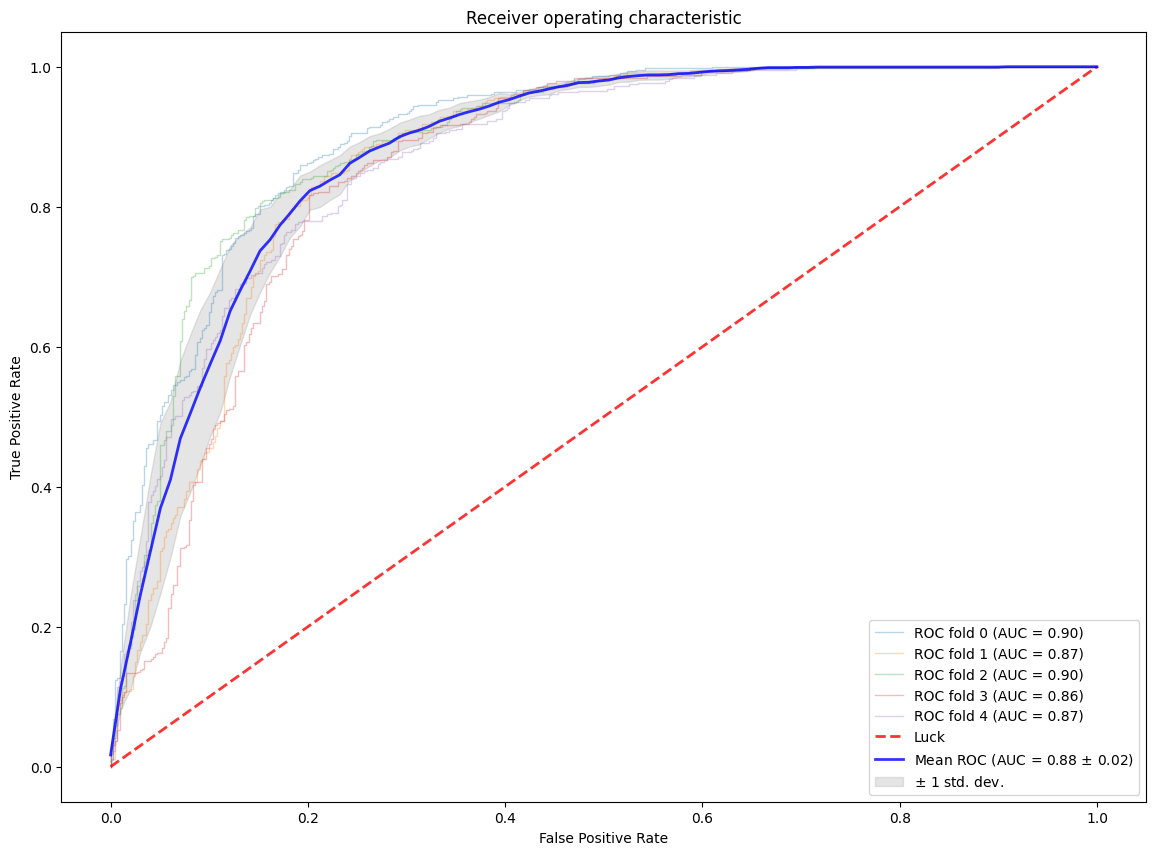

In [14]:
# Train Model
mlp_classifier = MLPClassifier(random_state=RANDOM_SEED)
mlp_classifier.fit(X_train, y_train)

# Generate predictions using the XGBoost model
mlp_predictions= mlp_classifier.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, mlp_predictions)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])

print("Confusion Matrix: ",cm)
print("Precision: ",precision)
mlp_scores = train_and_show_auc(mlp_classifier, features, target)